In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

# Define the LSTM-based model with multiple hidden layers
class LSTM_Lap_Generator(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_lstm_layers=2):
        super(LSTM_Lap_Generator, self).__init__()
        
        # LSTM layer stack
        self.lstm = nn.LSTM(input_size, hidden_size, num_lstm_layers, batch_first=True)
        
        # Fully connected layer for each time step
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        # Pass input through LSTM layers
        lstm_out, (hn, cn) = self.lstm(x)
        
        # Pass LSTM output through fully connected layer for each time step
        out = self.fc(lstm_out)
        
        return out

# Hyperparameters
input_size = 11  # Number of features in each time step
hidden_size = 128  # Number of hidden units in the LSTM
output_size = 11  # We want to output the same number of features as input
num_lstm_layers = 3  # Number of LSTM layers stacked
num_epochs = 50
batch_size = 32
learning_rate = 0.001

# Convert data to torch tensors
resampled_laps_tensor = torch.tensor(resampled_laps_array, dtype=torch.float32)

# Split the data into training and validation sets
train_data = resampled_laps_tensor[:int(0.8 * len(resampled_laps_tensor))]  # 80% for training
val_data = resampled_laps_tensor[int(0.8 * len(resampled_laps_tensor)):]  # 20% for validation

# DataLoader for batching
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size, shuffle=False)

# Initialize the model
model = LSTM_Lap_Generator(input_size=input_size, hidden_size=hidden_size, output_size=output_size, num_lstm_layers=num_lstm_layers)

# Loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training Loop
for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for batch in train_loader:
        optimizer.zero_grad()
        
        # Forward pass
        output = model(batch)
        
        # Compute the loss
        loss = criterion(output, batch)  # batch and output now have the same shape
        loss.backward()
        
        # Update weights
        optimizer.step()
        
        train_loss += loss.item()
    
    # Validation loop
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for batch in val_loader:
            output = model(batch)
            loss = criterion(output, batch)
            val_loss += loss.item()
    
    print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {train_loss / len(train_loader):.4f} | Val Loss: {val_loss / len(val_loader):.4f}")

# Save the trained model
torch.save(model.state_dict(), "lap_generator_model.pth")


In [ ]:
import torch
import torch.nn.functional as F
from sklearn.metrics import mean_absolute_error, r2_score

def evaluate_model(model, data_loader):
    model.eval()  # Set the model to evaluation mode
    mse_loss = 0
    rmse_loss = 0
    mae_loss = 0
    r2_loss = 0
    with torch.no_grad():
        for batch_idx, batch in enumerate(data_loader):
            print(f"Processing batch {batch_idx + 1}/{len(data_loader)}")
            
            # Check the type of batch to handle it accordingly
            if isinstance(batch, tuple):
                X_batch, y_batch = batch  # Unpack if it's a tuple
            else:
                X_batch = batch  # Just use batch if it's a single tensor
                y_batch = batch  # Assuming it's self-supervised or uses the same batch for input and output
            
            print(f"X_batch shape: {X_batch.shape}")
            print(f"y_batch shape: {y_batch.shape}")

            # Forward pass
            y_pred = model(X_batch)
            print(f"y_pred shape: {y_pred.shape}")

            # Flatten the tensors to 2D arrays (samples, features)
            y_batch_flat = y_batch.view(-1, y_batch.shape[-1]).cpu().numpy()  # Flatten y_batch
            y_pred_flat = y_pred.view(-1, y_pred.shape[-1]).cpu().numpy()  # Flatten y_pred

            # Calculate MSE, MAE, RMSE, R² using PyTorch functions
            mse_loss += torch.mean((y_pred - y_batch) ** 2).item()  # Use torch.mean instead of np.mean
            mae_loss += mean_absolute_error(y_batch_flat, y_pred_flat)  # Use flattened arrays for MAE
            r2_loss += r2_score(y_batch_flat, y_pred_flat)  # Use flattened arrays for R²
            rmse_loss += torch.sqrt(torch.mean((y_pred - y_batch) ** 2)).item()  # Use torch.sqrt for RMSE

            print(f"Batch {batch_idx + 1} processed.")

    # Calculate the average of the metrics
    num_batches = len(data_loader)
    mse_loss /= num_batches
    rmse_loss /= num_batches
    mae_loss /= num_batches
    r2_loss /= num_batches

    print(f"Evaluation complete. MSE: {mse_loss:.4f}, RMSE: {rmse_loss:.4f}, MAE: {mae_loss:.4f}, R2: {r2_loss:.4f}")
    return mse_loss, rmse_loss, mae_loss, r2_loss

# Evaluate the model
mse, rmse, mae, r2 = evaluate_model(model, val_loader)


In [2]:
import os
import pandas as pd
import numpy as np
from scipy.interpolate import PchipInterpolator
from sklearn.preprocessing import MinMaxScaler

# Path to the dataset
base_directory = '/kaggle/input/verstappen-monaco-data/verstappen_monaco_data'
years = ['2018', '2019', '2021', '2022', '2023', '2024']
features = ['Time', 'RPM', 'Speed', 'nGear', 'Throttle', 'Brake', 'Distance', 'RelativeDistance', 'X', 'Y', 'Z']

# List to store resampled laps
resampled_laps = []

# Initialize MinMaxScaler to normalize data
scaler = MinMaxScaler()

# Load and resample data to 600 time steps
for year in years:
    folder_path = os.path.join(base_directory, f'verstappen_monaco_{year}')
    if os.path.exists(folder_path):
        for lap_file in os.listdir(folder_path):
            file_path = os.path.join(folder_path, lap_file)
            df = pd.read_csv(file_path)
            df = df[features]  # Select relevant features
            
            # Get the original time steps (assuming it's the same for all laps)
            original_time_steps = df.shape[0]
            
            # Create new time steps (600 evenly spaced)
            new_time_steps = 600
            original_time_points = np.linspace(0, original_time_steps - 1, original_time_steps)
            new_time_points = np.linspace(0, original_time_steps - 1, new_time_steps)

            # Resample each feature using PCHIP
            resampled_lap = np.zeros((new_time_steps, len(features)))
            for i, feature in enumerate(features):
                interpolator = PchipInterpolator(original_time_points, df[feature].values)
                resampled_lap[:, i] = interpolator(new_time_points)
            
            # Normalize the features (except 'Time' which is usually non-numeric)
            resampled_lap[:, 1:] = scaler.fit_transform(resampled_lap[:, 1:])  # Normalize all features except Time
            
            resampled_laps.append(resampled_lap)

# Convert to numpy array
resampled_laps_array = np.array(resampled_laps)

# Check the shape of the resampled data
print("Shape of resampled laps data:", resampled_laps_array.shape)


Shape of resampled laps data: (454, 600, 11)


In [4]:
import torch
import torch.nn as nn
import torch.optim as optim

# Define the LSTM-based model with multiple layers, dropout, and early stopping
class LSTM_Lap_Generator(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=2, dropout=0.3):
        super(LSTM_Lap_Generator, self).__init__()
        
        # LSTM layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers=num_layers, batch_first=True, dropout=dropout)
        
        # Fully connected layer to output the predictions
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        # Pass input through LSTM layers
        lstm_out, (hn, cn) = self.lstm(x)
        
        # Pass the output of LSTM through the fully connected layer
        out = self.fc(lstm_out)
        
        return out

# Hyperparameters
input_size = 11  # Number of features in each time step
hidden_size = 512  # Increased hidden size for more capacity
output_size = 11  # We want to output the same number of features as input
num_epochs = 50
batch_size = 16
learning_rate = 0.001
num_layers = 3  # Increased number of LSTM layers
dropout = 0.3  # Dropout rate

# Convert data to torch tensors
resampled_laps_tensor = torch.tensor(resampled_laps_array, dtype=torch.float32)

# Split the data into training and validation sets
train_data = resampled_laps_tensor[:int(0.8 * len(resampled_laps_tensor))]  # 80% for training
val_data = resampled_laps_tensor[int(0.8 * len(resampled_laps_tensor)):]  # 20% for validation

# DataLoader for batching
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size, shuffle=False)

# Initialize the model
model = LSTM_Lap_Generator(input_size=input_size, hidden_size=hidden_size, output_size=output_size, num_layers=num_layers, dropout=dropout)

# Loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Early stopping parameters
best_val_loss = float('inf')
patience = 5  # Number of epochs to wait before early stopping
counter = 0

# Training Loop
for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for batch in train_loader:
        optimizer.zero_grad()
        
        # Forward pass
        output = model(batch)
        
        # Compute the loss
        loss = criterion(output, batch)
        loss.backward()
        
        # Update weights
        optimizer.step()
        
        train_loss += loss.item()
    
    # Validation loop
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for batch in val_loader:
            output = model(batch)
            loss = criterion(output, batch)
            val_loss += loss.item()

    # Check for early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        counter = 0  # Reset counter if we have a new best model
        torch.save(model.state_dict(), "best_lap_generator_model.pth")  # Save the best model
    else:
        counter += 1
        if counter >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break
    
    print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {train_loss / len(train_loader):.4f} | Val Loss: {val_loss / len(val_loader):.4f}")


Epoch 1/50 | Train Loss: 261.0761 | Val Loss: 2842.3040
Epoch 2/50 | Train Loss: 256.4671 | Val Loss: 2774.4646
Epoch 3/50 | Train Loss: 170.2532 | Val Loss: 2729.5675
Epoch 4/50 | Train Loss: 156.6029 | Val Loss: 2700.7152
Epoch 5/50 | Train Loss: 148.5679 | Val Loss: 2682.3799
Epoch 6/50 | Train Loss: 143.2646 | Val Loss: 2671.3246
Epoch 7/50 | Train Loss: 136.1759 | Val Loss: 2648.7948
Epoch 8/50 | Train Loss: 127.8340 | Val Loss: 2632.7459
Epoch 9/50 | Train Loss: 124.7190 | Val Loss: 2619.6755
Epoch 10/50 | Train Loss: 121.6705 | Val Loss: 2608.6528
Epoch 11/50 | Train Loss: 119.5955 | Val Loss: 2601.4563
Epoch 12/50 | Train Loss: 118.6494 | Val Loss: 2589.2657
Epoch 13/50 | Train Loss: 117.0272 | Val Loss: 2582.8924
Epoch 14/50 | Train Loss: 116.1065 | Val Loss: 2576.6111
Epoch 15/50 | Train Loss: 115.4811 | Val Loss: 2567.9344
Epoch 16/50 | Train Loss: 114.4805 | Val Loss: 2562.2377
Epoch 17/50 | Train Loss: 113.7992 | Val Loss: 2554.8709
Epoch 18/50 | Train Loss: 112.9879 | Val

In [5]:
import torch
import torch.nn.functional as F
from sklearn.metrics import mean_absolute_error, r2_score

def evaluate_model(model, data_loader):
    model.eval()  # Set the model to evaluation mode
    mse_loss = 0
    rmse_loss = 0
    mae_loss = 0
    r2_loss = 0
    with torch.no_grad():
        for batch_idx, batch in enumerate(data_loader):
            print(f"Processing batch {batch_idx + 1}/{len(data_loader)}")
            
            # Check the type of batch to handle it accordingly
            if isinstance(batch, tuple):
                X_batch, y_batch = batch  # Unpack if it's a tuple
            else:
                X_batch = batch  # Just use batch if it's a single tensor
                y_batch = batch  # Assuming it's self-supervised or uses the same batch for input and output
            
            print(f"X_batch shape: {X_batch.shape}")
            print(f"y_batch shape: {y_batch.shape}")

            # Forward pass
            y_pred = model(X_batch)
            print(f"y_pred shape: {y_pred.shape}")

            # Flatten the tensors to 2D arrays (samples, features)
            y_batch_flat = y_batch.view(-1, y_batch.shape[-1]).cpu().numpy()  # Flatten y_batch
            y_pred_flat = y_pred.view(-1, y_pred.shape[-1]).cpu().numpy()  # Flatten y_pred

            # Calculate MSE, MAE, RMSE, R² using PyTorch functions
            mse_loss += torch.mean((y_pred - y_batch) ** 2).item()  # Use torch.mean instead of np.mean
            mae_loss += mean_absolute_error(y_batch_flat, y_pred_flat)  # Use flattened arrays for MAE
            r2_loss += r2_score(y_batch_flat, y_pred_flat)  # Use flattened arrays for R²
            rmse_loss += torch.sqrt(torch.mean((y_pred - y_batch) ** 2)).item()  # Use torch.sqrt for RMSE

            print(f"Batch {batch_idx + 1} processed.")

    # Calculate the average of the metrics
    num_batches = len(data_loader)
    mse_loss /= num_batches
    rmse_loss /= num_batches
    mae_loss /= num_batches
    r2_loss /= num_batches

    print(f"Evaluation complete. MSE: {mse_loss:.4f}, RMSE: {rmse_loss:.4f}, MAE: {mae_loss:.4f}, R2: {r2_loss:.4f}")
    return mse_loss, rmse_loss, mae_loss, r2_loss

# Evaluate the model
mse, rmse, mae, r2 = evaluate_model(model, val_loader)


Processing batch 1/6
X_batch shape: torch.Size([16, 600, 11])
y_batch shape: torch.Size([16, 600, 11])
y_pred shape: torch.Size([16, 600, 11])
Batch 1 processed.
Processing batch 2/6
X_batch shape: torch.Size([16, 600, 11])
y_batch shape: torch.Size([16, 600, 11])
y_pred shape: torch.Size([16, 600, 11])
Batch 2 processed.
Processing batch 3/6
X_batch shape: torch.Size([16, 600, 11])
y_batch shape: torch.Size([16, 600, 11])
y_pred shape: torch.Size([16, 600, 11])
Batch 3 processed.
Processing batch 4/6
X_batch shape: torch.Size([16, 600, 11])
y_batch shape: torch.Size([16, 600, 11])
y_pred shape: torch.Size([16, 600, 11])
Batch 4 processed.
Processing batch 5/6
X_batch shape: torch.Size([16, 600, 11])
y_batch shape: torch.Size([16, 600, 11])
y_pred shape: torch.Size([16, 600, 11])
Batch 5 processed.
Processing batch 6/6
X_batch shape: torch.Size([11, 600, 11])
y_batch shape: torch.Size([11, 600, 11])
y_pred shape: torch.Size([11, 600, 11])
Batch 6 processed.
Evaluation complete. MSE: 23

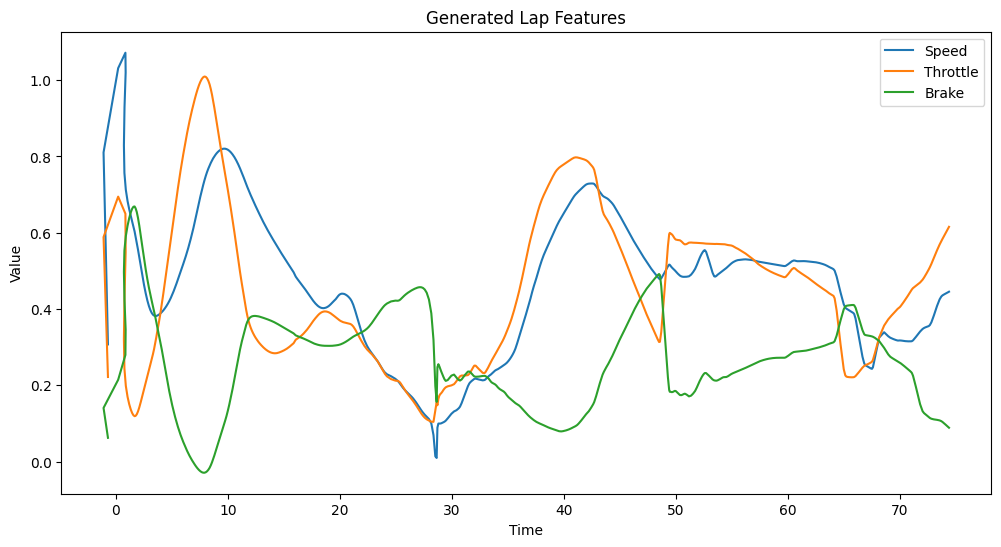

In [6]:
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Put model in evaluation mode
model.eval()

# Select a seed lap (random or from existing data)
seed_lap = torch.tensor(resampled_laps_array[0:1], dtype=torch.float32)  # Shape: (1, 600, 11)

# Generate predictions
with torch.no_grad():
    generated_lap = model(seed_lap).cpu().numpy()

# Convert to DataFrame
generated_lap_df = pd.DataFrame(generated_lap[0], columns=['Time', 'RPM', 'Speed', 'nGear', 'Throttle', 
                                                           'Brake', 'Distance', 'RelativeDistance', 'X', 'Y', 'Z'])

# Denormalize if necessary (assuming MinMaxScaler was used previously)
# generated_lap_df = scaler.inverse_transform(generated_lap_df)

# Save to CSV
generated_lap_df.to_csv("generated_lap.csv", index=False)

# Plot some key features
plt.figure(figsize=(12, 6))
plt.plot(generated_lap_df['Time'], generated_lap_df['Speed'], label='Speed')
plt.plot(generated_lap_df['Time'], generated_lap_df['Throttle'], label='Throttle')
plt.plot(generated_lap_df['Time'], generated_lap_df['Brake'], label='Brake')
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Generated Lap Features')
plt.legend()
plt.show()


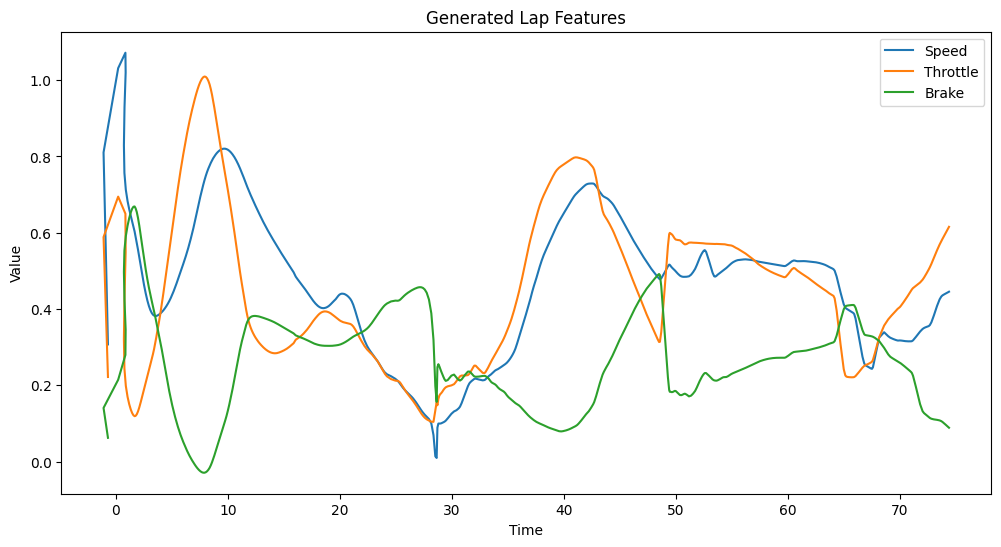

In [7]:
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Put model in evaluation mode
model.eval()

# Select a seed lap (random or from existing data)
seed_lap = torch.tensor(resampled_laps_array[0:1], dtype=torch.float32)  # Shape: (1, 600, 11)

# Generate predictions
with torch.no_grad():
    generated_lap = model(seed_lap).cpu().numpy()

# Convert to DataFrame
generated_lap_df = pd.DataFrame(generated_lap[0], columns=['Time', 'RPM', 'Speed', 'nGear', 'Throttle', 
                                                           'Brake', 'Distance', 'RelativeDistance', 'X', 'Y', 'Z'])

# Denormalize if necessary (assuming MinMaxScaler was used previously)
# generated_lap_df = scaler.inverse_transform(generated_lap_df)

# Save to CSV
generated_lap_df.to_csv("generated_lap.csv", index=False)

# Plot some key features
plt.figure(figsize=(12, 6))
plt.plot(generated_lap_df['Time'], generated_lap_df['Speed'], label='Speed')
plt.plot(generated_lap_df['Time'], generated_lap_df['Throttle'], label='Throttle')
plt.plot(generated_lap_df['Time'], generated_lap_df['Brake'], label='Brake')
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Generated Lap Features')
plt.legend()
plt.show()


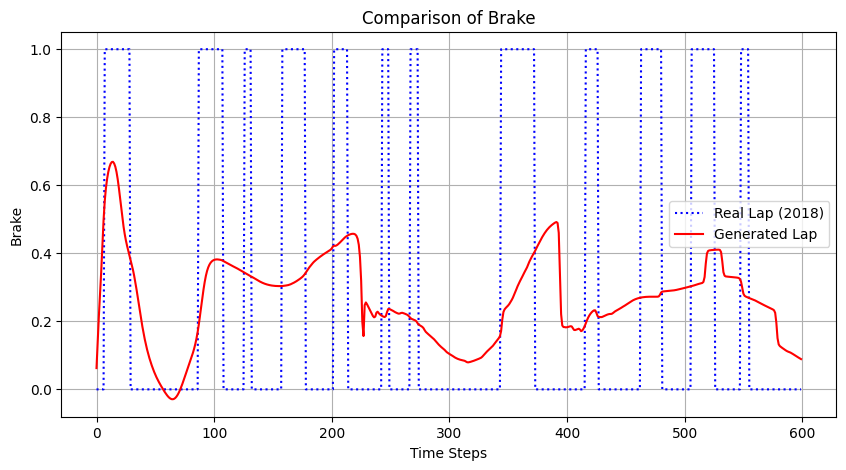

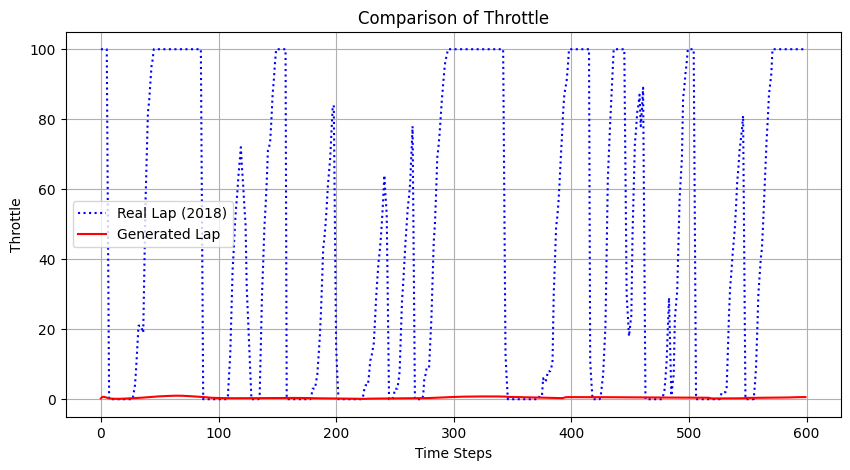

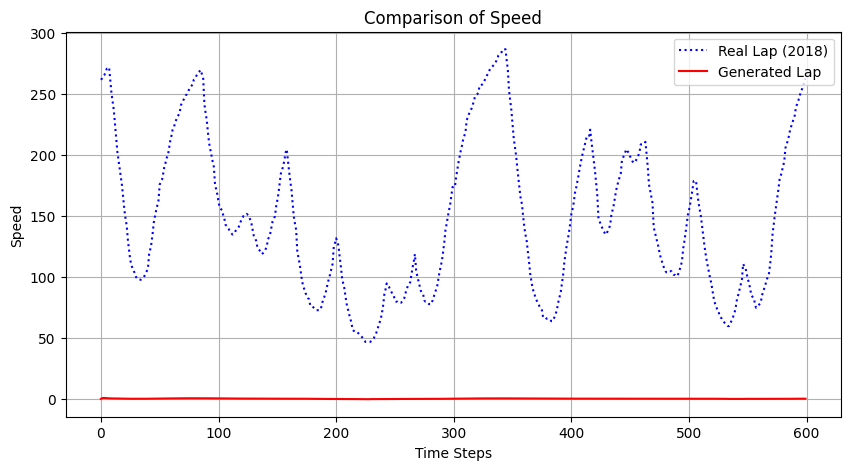

Compared real lap: Lap_3.0.csv from year 2018


In [8]:
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Paths to real and generated laps
real_laps_dir = '/kaggle/input/verstappen-monaco-data/verstappen_monaco_data'
#real_laps_dir = '/content/drive/MyDrive/verstappen_monaco_data'
generated_lap_path = '/kaggle/working/generated_lap.csv'

# Load generated lap data
generated_lap = pd.read_csv(generated_lap_path)

# Randomly select a year and lap file from the real data
selected_year = random.choice(['2018', '2019', '2021', '2022', '2023', '2024'])
real_lap_folder = os.path.join(real_laps_dir, f'verstappen_monaco_{selected_year}')
real_lap_files = os.listdir(real_lap_folder)

if not real_lap_files:
    raise FileNotFoundError("No real lap files found in the selected year directory.")

random_real_lap_file = random.choice(real_lap_files)
real_lap_path = os.path.join(real_lap_folder, random_real_lap_file)

# Load real lap data
real_lap = pd.read_csv(real_lap_path)

# Ensure both laps have the same number of time steps (resample if necessary)
real_lap = real_lap.iloc[:600]  # Take first 600 rows to match
generated_lap = generated_lap.iloc[:600]

# Parameters to compare
parameters = ['Brake', 'Throttle', 'Speed']

# Generate separate plots for each parameter
for param in parameters:
    plt.figure(figsize=(10, 5))
    plt.plot(real_lap[param], label=f'Real Lap ({selected_year})', linestyle='dotted', color='blue')
    plt.plot(generated_lap[param], label='Generated Lap', linestyle='solid', color='red')
    plt.title(f'Comparison of {param}')
    plt.xlabel('Time Steps')
    plt.ylabel(param)
    plt.legend()
    plt.grid()
    plt.show()

print(f"Compared real lap: {random_real_lap_file} from year {selected_year}")


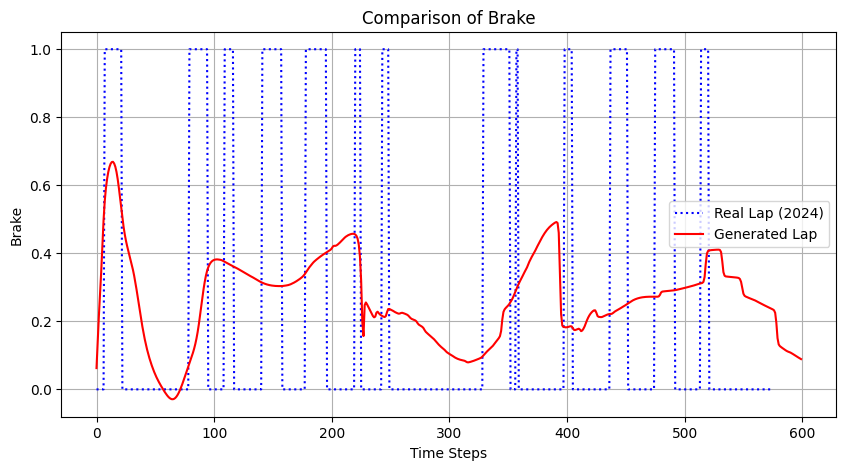

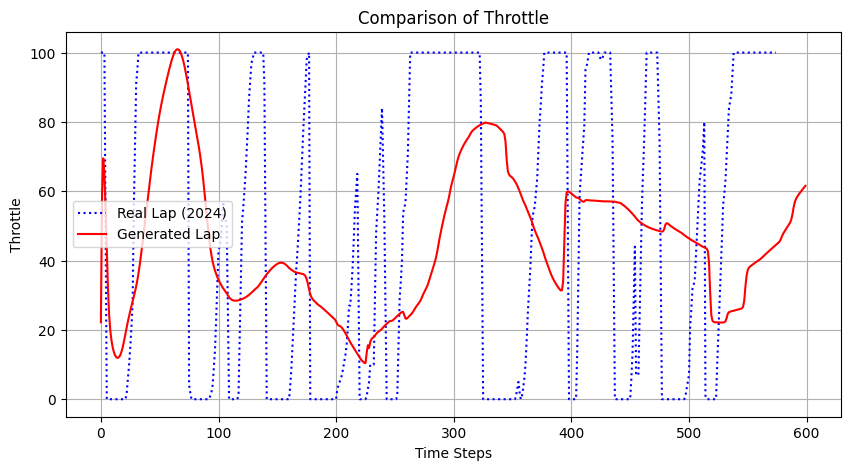

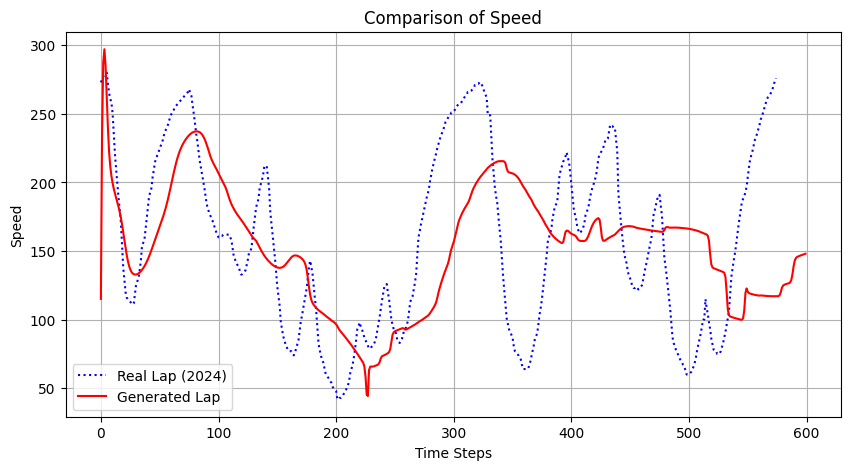

Compared real lap: Lap_61.0.csv from year 2024


In [9]:
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

# Paths to real and generated laps
real_laps_dir = '/kaggle/input/verstappen-monaco-data/verstappen_monaco_data'
generated_lap_path = '/kaggle/working/generated_lap.csv'

# Load generated lap data
generated_lap = pd.read_csv(generated_lap_path)

# Randomly select a year and lap file from the real data
selected_year = random.choice(['2018', '2019', '2021', '2022', '2023', '2024'])
real_lap_folder = os.path.join(real_laps_dir, f'verstappen_monaco_{selected_year}')
real_lap_files = os.listdir(real_lap_folder)

if not real_lap_files:
    raise FileNotFoundError("No real lap files found in the selected year directory.")

random_real_lap_file = random.choice(real_lap_files)
real_lap_path = os.path.join(real_lap_folder, random_real_lap_file)

# Load real lap data
real_lap = pd.read_csv(real_lap_path)

# Ensure both laps have the same number of time steps
real_lap = real_lap.iloc[:600]  # Take first 600 rows to match
generated_lap = generated_lap.iloc[:600]

# Parameters to compare
parameters = ['Brake', 'Throttle', 'Speed']

# Normalize the real lap to find the original scaling values
scaler = MinMaxScaler()
scaler.fit(real_lap[parameters])  # Fit scaler to real lap values

# Denormalize the generated lap
generated_lap[parameters] = scaler.inverse_transform(generated_lap[parameters])

# Generate separate plots for each parameter
for param in parameters:
    plt.figure(figsize=(10, 5))
    plt.plot(real_lap[param], label=f'Real Lap ({selected_year})', linestyle='dotted', color='blue')
    plt.plot(generated_lap[param], label='Generated Lap', linestyle='solid', color='red')
    plt.title(f'Comparison of {param}')
    plt.xlabel('Time Steps')
    plt.ylabel(param)
    plt.legend()
    plt.grid()
    plt.show()

print(f"Compared real lap: {random_real_lap_file} from year {selected_year}")


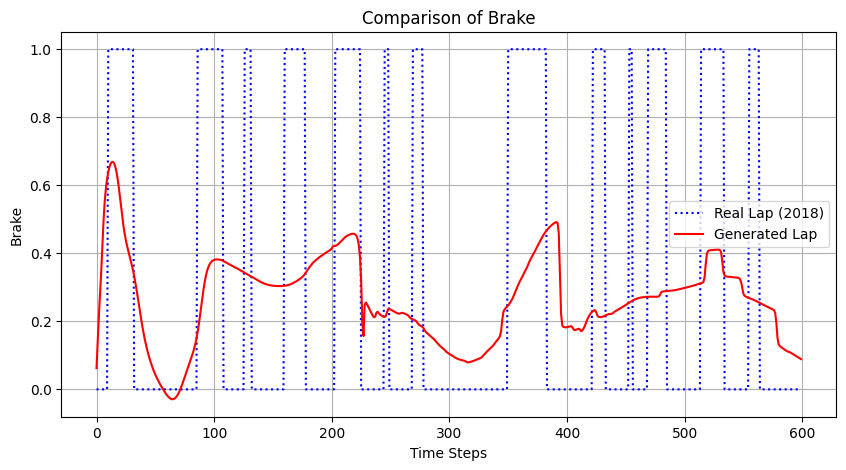

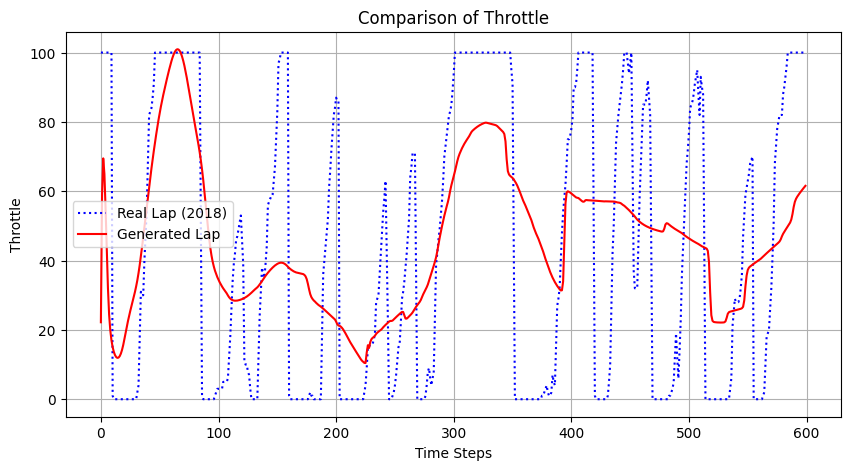

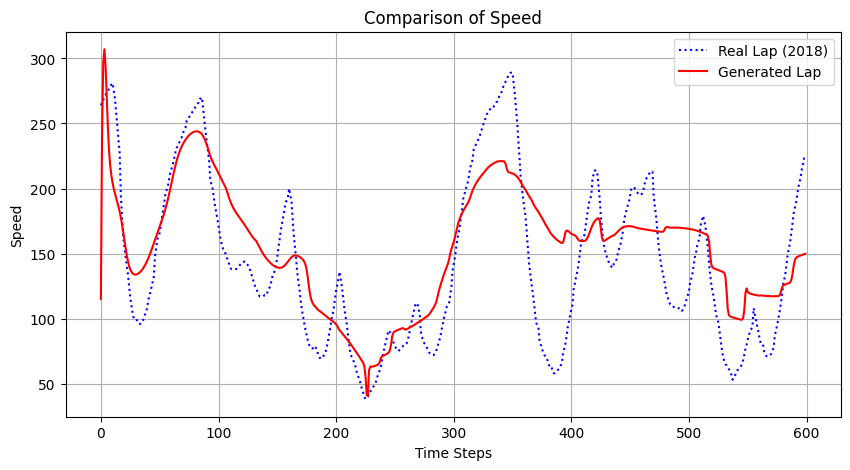

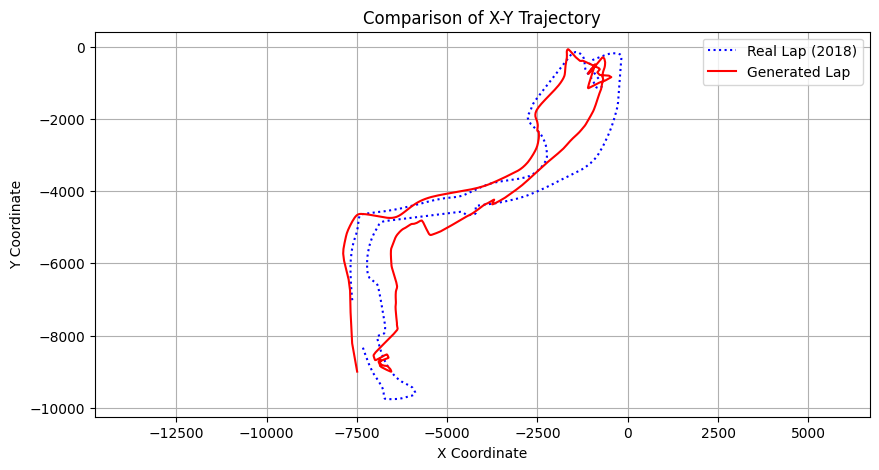

Compared real lap: Lap_18.0.csv from year 2018


In [10]:
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

# Paths to real and generated laps
real_laps_dir = '/kaggle/input/verstappen-monaco-data/verstappen_monaco_data'
generated_lap_path = '/kaggle/working/generated_lap.csv'

# Load generated lap data
generated_lap = pd.read_csv(generated_lap_path)

# Randomly select a year and lap file from the real data
selected_year = random.choice(['2018', '2019', '2021', '2022', '2023', '2024'])
real_lap_folder = os.path.join(real_laps_dir, f'verstappen_monaco_{selected_year}')
real_lap_files = os.listdir(real_lap_folder)

if not real_lap_files:
    raise FileNotFoundError("No real lap files found in the selected year directory.")

random_real_lap_file = random.choice(real_lap_files)
real_lap_path = os.path.join(real_lap_folder, random_real_lap_file)

# Load real lap data
real_lap = pd.read_csv(real_lap_path)

# Ensure both laps have the same number of time steps
real_lap = real_lap.iloc[:600]  # Take first 600 rows to match
generated_lap = generated_lap.iloc[:600]

# Parameters to compare
parameters = ['Brake', 'Throttle', 'Speed', 'X', 'Y']

# Normalize the real lap to find the original scaling values
scaler = MinMaxScaler()
scaler.fit(real_lap[parameters])  # Fit scaler to real lap values

# Denormalize the generated lap
generated_lap[parameters] = scaler.inverse_transform(generated_lap[parameters])

# Generate separate plots for each parameter
for param in ['Brake', 'Throttle', 'Speed']:
    plt.figure(figsize=(10, 5))
    plt.plot(real_lap[param], label=f'Real Lap ({selected_year})', linestyle='dotted', color='blue')
    plt.plot(generated_lap[param], label='Generated Lap', linestyle='solid', color='red')
    plt.title(f'Comparison of {param}')
    plt.xlabel('Time Steps')
    plt.ylabel(param)
    plt.legend()
    plt.grid()
    plt.show()

# Plot X-Y trajectory comparison
plt.figure(figsize=(10, 5))
plt.plot(real_lap['X'], real_lap['Y'], label=f'Real Lap ({selected_year})', linestyle='dotted', color='blue')
plt.plot(generated_lap['X'], generated_lap['Y'], label='Generated Lap', linestyle='solid', color='red')
plt.title('Comparison of X-Y Trajectory')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.legend()
plt.grid()
plt.axis('equal')  # Ensure equal aspect ratio
plt.show()

print(f"Compared real lap: {random_real_lap_file} from year {selected_year}")
